In [1]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [2]:
tf.__version__

'1.15.2'

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
import os
import re
import numpy as np
import pandas as pd
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Model, Sequential
#import transformers as ppb
import torch

import warnings
warnings.filterwarnings('ignore')

In [0]:
os.chdir("/content/drive/My Drive/MIDS/W266/")
!ls

# Load data

Dataset from: http://diego.asu.edu/Publications/ADRMine.html

In [7]:
#load data
data =  pd.read_csv('binary_tweet_dataset/binary_tweets_valid.csv', lineterminator='\n')
data.drop(columns=["index"], inplace=True)
data.head()

,tweet_id,user_id,id,tweet,url
0,339867818843594756,246979971,0,"@DoctorChristian scared to start fluoxetine, w...",http://twitter.com/246979971/status/3398678188...
1,349294537367236611,149749939,0,"@IntuitiveGal1 ok, if you stopped taking the L...",http://twitter.com/149749939/status/3492945373...
2,354256195432882177,54516759,0,Novartis announces secukinumab (AIN457) demons...,http://twitter.com/54516759/status/35425619543...
3,352456944537178112,1267743056,1,"""U wailed all night; now y'r disembodied sobbi...",http://twitter.com/1267743056/status/352456944...
4,332479707004170241,273421529,0,@irapaps you're so fucking selfish. I've got L...,http://twitter.com/273421529/status/3324797070...


In [0]:
#remove newline characters from tweets
def preprocess(s):
  s = re.sub(r'\n', ' ', s)
  return(s)
data['tweet'] = data['tweet'].apply(lambda x: preprocess(x))

In [0]:
split_data, test_data = train_test_split(data[['tweet','id']], test_size=0.2, random_state=0, stratify=data["id"])
train_data, dev_data = train_test_split(split_data, test_size=0.25, random_state=0, stratify=split_data["id"])

In [16]:
train_data.shape[0], dev_data.shape[0], test_data.shape[0]

(2501, 834, 834)

In [0]:
train_data.to_csv('./binary_tweet_dataset/train.tsv', sep='\t', index=False, header=False)
dev_data.to_csv('./binary_tweet_dataset/dev.tsv', sep='\t', index=False, header=False)
test_data.to_csv('./binary_tweet_dataset/test.tsv', sep='\t', index=False, header=False)

# Fine tune with BERT


Classification code adapted from: https://github.com/google-research/bert

In [0]:
BERT_BASE_DIR="/content/drive/My Drive/MIDS/W266/W266/model/uncased_L-12_H-768_A-12"
DATA_DIR="/content/drive/My Drive/MIDS/W266/binary_tweet_dataset/undersampled"
TRAINED_CLASSIFIER="/content/drive/My Drive/MIDS/W266/trained_models/binary/bert_uncased_binary_undersampled"

In [0]:
if not os.path.exists(TRAINED_CLASSIFIER):
  os.makedirs(TRAINED_CLASSIFIER)

In [0]:
!ls "$BERT_BASE_DIR"

In [0]:
!python ./bert/run_classifier.py \
  --task_name=tweet \
  --do_train=true \
  --do_eval=true \
  --do_predict=true \
  --data_dir="$DATA_DIR" \
  --vocab_file="$BERT_BASE_DIR/vocab.txt" \
  --bert_config_file="$BERT_BASE_DIR/bert_config.json" \
  --init_checkpoint="$BERT_BASE_DIR/model.ckpt-100000" \
  --max_seq_length=128 \
  --train_batch_size=32 \
  --learning_rate=2e-5 \
  --num_train_epochs=3.0 \
  --output_dir="$TRAINED_CLASSIFIER"

In [0]:
test_data = pd.read_csv(DATA_DIR+"/test.tsv", delimiter='\t', header=None, lineterminator='\n')
test_y = test_data[1]

In [0]:
test_results = pd.read_csv(TRAINED_CLASSIFIER+"/test_results.tsv", delimiter='\t', header=None)
test_prob = test_results[1]
test_pred = [1 if x >= 0.5 else 0 for x in test_prob]

In [18]:
#test performance
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),3)}")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),3)}")

accuracy: 0.841
f1-score: 0.546


In [8]:
!ls "$TRAINED_CLASSIFIER"

checkpoint				     model.ckpt-0.meta
eval					     model.ckpt-78.data-00000-of-00001
eval_results.txt			     model.ckpt-78.index
eval.tf_record				     model.ckpt-78.meta
events.out.tfevents.1586038550.185665327be0  predict.tf_record
graph.pbtxt				     test_results.tsv
model.ckpt-0.data-00000-of-00001	     train.tf_record
model.ckpt-0.index


# Extract features from fine tuned BERT models

In [0]:
EXTRACTED_FEATURES = TRAINED_CLASSIFIER+'/extracted_features'
if not os.path.exists(EXTRACTED_FEATURES):
  os.makedirs(EXTRACTED_FEATURES)

In [0]:
!python ./bert/extract_features.py \
  --input_file="$DATA_DIR/dev.tsv" \
  --output_file="$EXTRACTED_FEATURES/dev_features.json" \
  --vocab_file="$BERT_BASE_DIR/vocab.txt" \
  --bert_config_file="$BERT_BASE_DIR/bert_config.json" \
  --init_checkpoint="$TRAINED_CLASSIFIER/model.ckpt-78" \
  --layers=-1,-2,-3,-4 \
  --max_seq_length=128 \
  --batch_size=8

In [0]:
def parse_embeddings(line, layer=0):
    """
    Parses json features output file from BERT model.
    
    Inputs
    i: index of the examples
    layer: 0 corresponds to the last layer(-1), 1 corresponds to second to last layer(-2), etc
    
    Outputs
    tokens: list of tokens of the example
    embeds: embeddings of all the tokens, dimensions are (number of tokens, embedding length)
    embeds_avg: average of the embeddings across all the tokens, dimension are (1, embedding length)
    """
    embed_json = pd.DataFrame(json.loads(line))
    num_tokens = embed_json.shape[0]
    tokens = [embed_json["features"][x]["token"] for x in range(num_tokens)]
    embeds = np.array([np.array(embed_json["features"][x]["layers"][layer]["values"]) for x in range(num_tokens)])
    #embeds_avg = np.mean(embeds, axis=0)
    return(tokens, embeds)

In [0]:
def get_features(filepath):
  with open(filepath) as f:
    lines = f.readlines()
  all_tokens = []
  all_embeds = []
  for i in range(len(lines)):
    tokens, embeds = parse_embeddings(lines[i], 0)
    all_tokens.append(tokens)
    all_embeds.append(embeds)
  return(all_tokens, all_embeds)

In [0]:
EXTRACTED_FEATURES = "/content/drive/My Drive/MIDS/W266/trained_models/binary/bert_uncased_binary_undersampled/extracted_features"
DATA_DIR="/content/drive/My Drive/MIDS/W266/binary_tweet_dataset/undersampled"

In [0]:
train_tokens, train_embeds = get_features(EXTRACTED_FEATURES+"/train_features.json")

In [0]:
dev_tokens, dev_embeds = get_features(EXTRACTED_FEATURES+"/dev_features.json")

In [0]:
test_tokens, test_embeds = get_features(EXTRACTED_FEATURES+"/test_features.json")

In [0]:
train_data = pd.read_csv(DATA_DIR+"/train.tsv", delimiter="\t", header=None, lineterminator='\n')
train_y = train_data[1]
train_x = train_embeds
train_x0 = np.array([x[0] for x in train_embeds])

In [0]:
dev_data = pd.read_csv(DATA_DIR+"/dev.tsv", delimiter="\t", header=None, lineterminator='\n')
dev_y = dev_data[1]
dev_x = dev_embeds
dev_x0 = np.array([x[0] for x in dev_embeds])

In [0]:
#combine train and dev sets
train_dev_y = np.append(train_data[1], dev_data[1])
train_dev_x = np.append(train_x, dev_x, axis=0)
train_dev_x0 = np.append(train_x0, dev_x0, axis=0)

In [17]:
#training data shapes
print(f"shape of y: {train_dev_y.shape}")
print(f"shape of x (cls token embedding): {train_dev_x0.shape}")
print(f"shape of x (embeddings): {train_dev_x.shape}")
print(f"shape of embeddings of first example: {train_dev_x[0].shape}")
print(f"shape of embeddings of second example: {train_dev_x[1].shape}")

shape of y: (1669,)
shape of x (cls token embedding): (1669, 768)
shape of x (embeddings): (1669,)
shape of embeddings of first example: (53, 768)
shape of embeddings of second example: (29, 768)


In [0]:
test_data = pd.read_csv(DATA_DIR+"/test.tsv", delimiter="\t", header=None, lineterminator='\n')
test_y = test_data[1]
test_x = np.array(test_embeds)
test_x0 = np.array([x[0] for x in test_embeds])

In [19]:
#test data shapes
print(f"shape of y: {test_y.shape}")
print(f"shape of x (cls token embedding: {test_x0.shape}")
print(f"shape of x (embeddings): {test_x.shape}")
print(f"shape of embeddings of first example: {test_x[0].shape}")
print(f"shape of embeddings of second example: {test_x[1].shape}")

shape of y: (834,)
shape of x (cls token embedding: (834, 768)
shape of x (embeddings): (834,)
shape of embeddings of first example: (30, 768)
shape of embeddings of second example: (33, 768)


### Front pad embeddings to max token length

95 percentile of token lengths for training data: 49.0
max token length for training data: 102


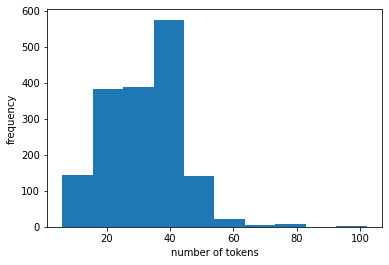

In [29]:
train_token_len = [len(x) for x in train_tokens]
train_token_len.extend([len(x) for x in dev_tokens])
plt.hist(train_token_len)
plt.xlabel("number of tokens")
plt.ylabel("frequency")
print(f"95 percentile of token lengths for training data: {np.percentile(train_token_len, 95)}")
print(f"max token length for training data: {np.max(train_token_len)}")

95 percentile of token lengths for test data: 50.0
max token length for test data: 77


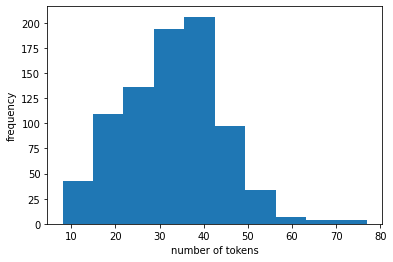

In [30]:
test_token_len = [len(x) for x in test_tokens]
plt.hist(test_token_len)
plt.xlabel("number of tokens")
plt.ylabel("frequency")
print(f"95 percentile of token lengths for test data: {np.percentile(test_token_len, 95)}")
print(f"max token length for test data: {np.max(test_token_len)}")

In [0]:
def pad_embeddings(example, max_len):
  example_len = example.shape[0]
  padding = np.zeros((max_len-example_len,768))
  example_padding = np.append(padding, example, axis =0)
  return (example_padding)

In [0]:
max_len = 102
train_dev_x_pad = np.array([pad_embeddings(x, max_len) for x in train_dev_x])

In [0]:
test_x_pad = np.array([pad_embeddings(x, max_len) for x in test_x])

In [24]:
train_dev_x_pad.shape

(1669, 102, 768)

In [25]:
test_x_pad.shape

(834, 102, 768)

### CNN with BERT extracted features

In [36]:
#CNN
embed_dim = 5
num_filters = [10, 10, 10, 10]
kernel_sizes = [5, 10, 15, 20]
dense_layer_dims = []
dropout_rate = 0.8

input_layer = tf.keras.layers.Input(shape=(102,768), name="input")

conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(input_layer)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

# Concat the feature maps from each different size.
layer = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

#layer = keras.layers.Dropout(rate=dropout_rate, name='dropout')(layer)

for dim in dense_layer_dims:  
  layer = keras.layers.Dense(dim, activation='relu')(layer)

classification_output = keras.layers.Dense(1, activation='sigmoid', name='sigmoid')(layer)

cnn_model = keras.Model(input_layer, classification_output)
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

cnn_model.reset_states()
cnn_model.fit(train_dev_x_pad, train_dev_y, validation_data=[test_x_pad, test_y], epochs=10)
cnn_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1669 samples, validate on 834 samples
Epoch 1/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 0.2475 - acc: 0.9185 - val_loss: 0.2056 - val_acc: 0.9077
Epoch 2/10
1669/1669 [==============================] - 1s 758us/sample - loss: 0.1158 - acc: 0.9551 - val_loss: 0.1408 - val_acc: 0.9424
Epoch 3/10
1669/1669 [==============================] - 1s 750us/sample - loss: 0.0628 - acc: 0.9808 - val_loss: 0.1319 - val_acc: 0.9508
Epoch 4/10
1669/1669 [==============================] - 1s 752us/sample - loss: 0.0293 - acc: 0.9940 - val_loss: 0.0779 - val_acc: 0.9700
Epoch 5/10
1669/1669 [==============================] - 1s 745us/sample - loss: 0.0119 - acc: 0.9994 - val_loss: 0.0524 - val_acc: 0.9856
Epoch 6/10
1669/1669 [==============================] - 1s 753us/sample - loss: 0.0078 - a

In [37]:
#test performance
test_prob = cnn_model.predict(test_x_pad)
test_pred = np.where(test_prob >=0.5, 1, 0)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),3)}")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),3)}")

accuracy: 0.989
f1-score: 0.951


In [38]:
cm = confusion_matrix(test_pred, test_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,88.49%,0.6%
true pos,0.48%,10.43%


### LSTM with BERT extracted features

In [27]:
#LSTM
input_layer = tf.keras.layers.Input(shape=(102,768), name="input")
lstm_output = LSTM(100, input_shape=(768,102,), name="lstm")(input_layer)
classification_output = Dense(1, activation="sigmoid", name="sigmoid")(lstm_output)

lstm_model = Model(input_layer, classification_output)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.reset_states()
lstm_model.fit(train_dev_x_pad, train_dev_y, epochs=10)
lstm_model.summary()

Train on 1669 samples
Epoch 1/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 0.1471 - acc: 0.9413
Epoch 2/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 0.0264 - acc: 0.9940
Epoch 3/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 0.0038 - acc: 0.9994
Epoch 4/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 0.0013 - acc: 1.0000
Epoch 5/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 7.5997e-04 - acc: 1.0000
Epoch 6/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 5.3446e-04 - acc: 1.0000
Epoch 7/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 3.9911e-04 - acc: 1.0000
Epoch 8/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 3.1224e-04 - acc: 1.0000
Epoch 9/10
1669/1669 [==============================] - 7s 4ms/sample - loss: 2.5616e-04 - acc: 1.0000
Epoch 10/10
1669/1669 [==============================] - 7s 4ms/sam

In [41]:
test_prob = lstm_model.predict(test_x_pad)
test_pred = np.where(test_prob >=0.5, 1, 0)
test_pred = pd.Series(test_pred.flatten())
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),3)}")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),3)}")

accuracy: 0.999
f1-score: 0.995


In [29]:
cm = confusion_matrix(test_pred, test_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,88.97%,0.12%
true pos,0.0%,10.91%


Error analysis

In [45]:
results = pd.concat([test_y,test_pred], axis=1)
results.columns = ["test_y", "test_pred"]
results[results["test_y"]!=results["test_pred"]]

,test_y,test_pred
826,1,0


In [48]:
test_data[0][826]

"@sapphire20 to it, and now I'm on Humira with just the bloat to battle. Things sometimes get super shitty in every sense. But stay strong xx"

### Logistic Regression with BERT extracted features for CLS token

In [42]:
#logistic regression
param_grid = {"C": np.linspace(0.0001, 100, 30),
              "penalty": ["l1", "l2", "elasticnet"],
              "class_weight": ["balanced", None]}
lr = LogisticRegression(random_state=0)
search = GridSearchCV(lr, param_grid, cv=3, scoring='f1')
search.fit(train_dev_x0, train_dev_y)
search.best_params_

{'C': 58.62073103448276, 'class_weight': 'balanced', 'penalty': 'l2'}

In [44]:
test_pred = search.predict(test_x0)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),3)}")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),3)}")

accuracy: 0.95
f1-score: 0.786


In [45]:
cm = confusion_matrix(test_pred, test_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,85.73%,1.8%
true pos,3.24%,9.23%
